<a href="https://colab.research.google.com/github/ehdob-cid20/mlops-deploy/blob/main/CDN_Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Health Insurance Cross Sell Prediction - Kaggle</strong></h1>

<h3><strong>Data Science for Business</strong></h3>

**Goal**:
Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

*   Dataset: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

***Teacher:*** Marcio Palheta Piedade

***Group:*** Cássio de Paula , Dilmara Ferreira, Edson Brilhante e Paulo Moraes

<h4><strong>Melhores Modelos</strong></h4>



*   Logistic Regression
*   Random Florest
*   XGBoost



<h4><strong>Campos/Conceito</strong></h4>

Total de 12 campos, sendo nenhum nulo, 3 categoricos  e 9 númericos.

*  id - Unique ID for the customer
*  Gender - Gender of the customer
*  Age - Age of the customer
*  Driving_License - 0 : Customer does not have DL, 1 : Customer already has DL
*  Region_Code -  Unique code for the region of the customer
*  Previously_Insured - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
*  Vehicle_Age - Age of the Vehiclevy  
*  Vehicle_Damage - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
*  Annual_Premium - The amount customer needs to pay as premium in the year
*  PolicySalesChannel - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
*  Vintage - Number of Days, Customer has been associated with the company.
*  Response - 1 : Customer is interested, 0 : Customer is not interested

# 1. Importando Bibliotecas

In [1]:
!pip install shap 

     |████████████████████████████████| 371 kB 38.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509241 sha256=960f898a8c09aeb92cd8d12066c33265e262421e9b3c46f9133a4e6821e099a5
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
pd.options.display.max_columns = None

In [4]:
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

#2. Carregando Dados

In [5]:
df_train = pd.read_csv('train.csv', sep=',')
df_train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


#3. Análise Exploratoria

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
#Princiapis categorias
categoricals = df_train.select_dtypes(exclude=[np.number])
categoricals.describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


In [9]:
#Categorias por variavel
n = categoricals
for c in n.columns:
    print('{:<14}'.format(c), df_train[c].unique())

Gender         ['Male' 'Female']
Vehicle_Age    ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage ['Yes' 'No']


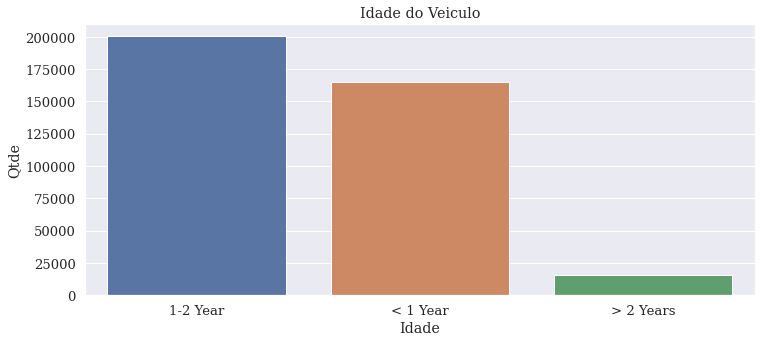

In [10]:
plt.figure(figsize = (12,5))

ax = sns.countplot(x = 'Vehicle_Age', 
                   data = df_train, 
                   order = df_train['Vehicle_Age'].value_counts().index)

ax.set_title('Idade do Veiculo')
ax.set_xlabel('Idade')
ax.set_ylabel('Qtde')

plt.show()

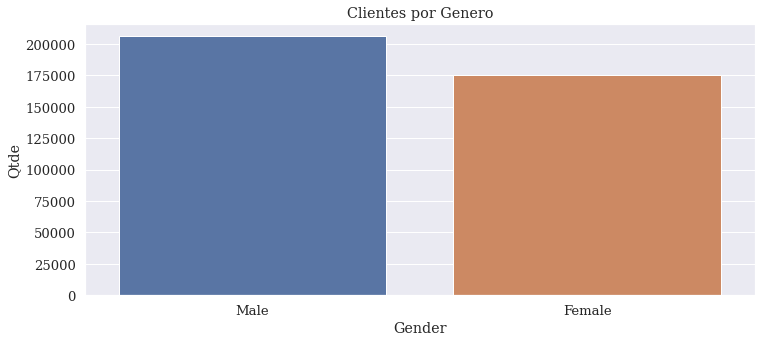

In [11]:
plt.figure(figsize = (12,5))

ax = sns.countplot(x = 'Gender', 
                   data = df_train, 
                   order = df_train['Gender'].value_counts().index)

ax.set_title('Clientes por Genero')
ax.set_xlabel('Gender')
ax.set_ylabel('Qtde')

plt.show()

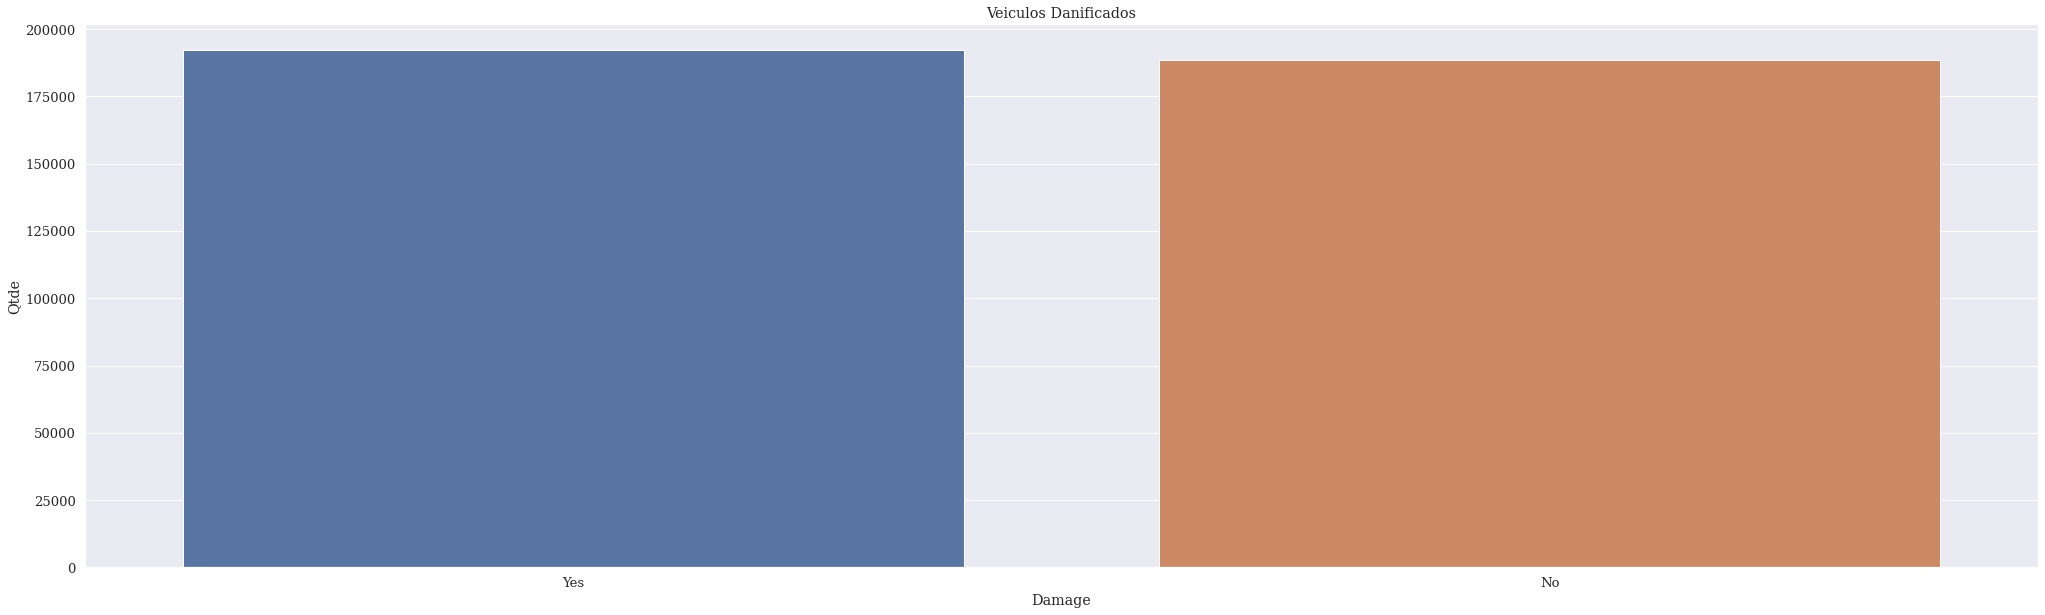

In [12]:
plt.figure(figsize = (35,10))

ax = sns.countplot(x = 'Vehicle_Damage', 
                   data = df_train, 
                   order = df_train['Vehicle_Damage'].value_counts().index)

ax.set_title('Veiculos Danificados')
ax.set_xlabel('Damage')
ax.set_ylabel('Qtde')

plt.show()

In [13]:
df_train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [14]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
null_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
null_data.head(20)

,Total,Percent
Response,0,0.0
Vintage,0,0.0
Policy_Sales_Channel,0,0.0
Annual_Premium,0,0.0
Vehicle_Damage,0,0.0
Vehicle_Age,0,0.0
Previously_Insured,0,0.0
Region_Code,0,0.0
Driving_License,0,0.0
Age,0,0.0


In [15]:
resposta = df_train['Response'].value_counts().reset_index()
resposta = resposta.rename(columns={'index': 'resposta', 'Response': 'qtde'})
resposta

,resposta,qtde
0,0,334399
1,1,46710


In [16]:
correlacao = df_train.corr()
correlacao

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,0.001561,-0.000564,-0.000572,0.002457,0.003027,-0.002837,-0.000630,-0.001368
Age,0.001561,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.003027,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.000630,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,-0.001368,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


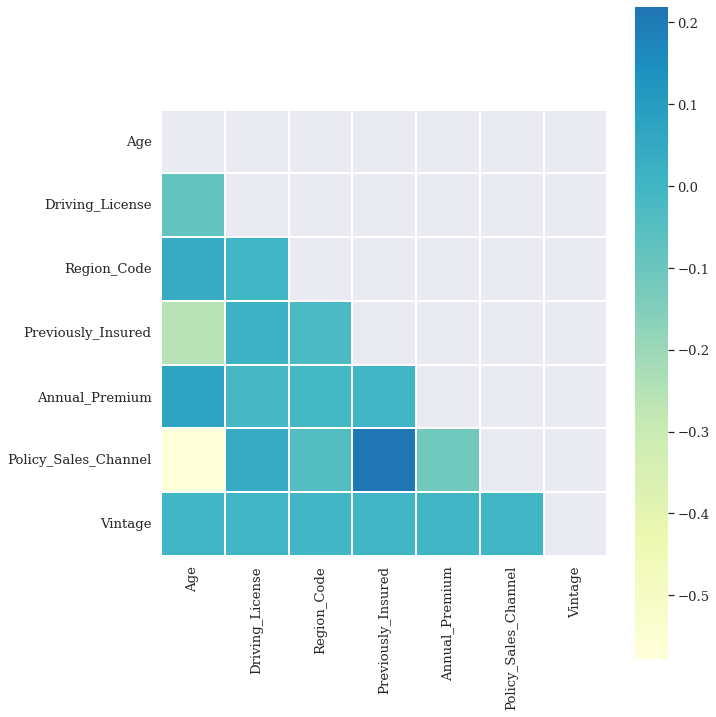

In [17]:
fet_set = df_train.drop(labels=['id','Response'],axis=1)
def plot_diag_heatmap(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 12))
    sns.heatmap(corr, mask=mask, cmap='YlGnBu', center=0,square=True, linewidths=1, cbar_kws={"shrink": 1.0})
plot_diag_heatmap(fet_set)

#4. Pré-processamento

In [18]:
#Removendo campo
df_train.drop(['id'], axis='columns', inplace=True)

In [19]:
#Convertendo string em numeros
label_encoder = LabelEncoder()
df_train['Gender'] = label_encoder.fit_transform(list(df_train['Gender'].values))
df_train['Vehicle_Age'] = label_encoder.fit_transform(list(df_train['Vehicle_Age'].values))
df_train['Vehicle_Damage'] = label_encoder.fit_transform(list(df_train['Vehicle_Damage'].values))


In [20]:
df_train.head(2)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,0,0,33536.0,26.0,183,0


In [21]:
target_names = ["Não","Sim"]

##4.1 Dividindo Treino e Teste

In [22]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_train.drop(columns='Response'), 
                     df_train['Response'], 
                     test_size=0.33, random_state=42)

In [23]:
y_train.value_counts(normalize=True)

0    0.877831
1    0.122169
Name: Response, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

0    0.876636
1    0.123364
Name: Response, dtype: float64

In [25]:
print('Amostras de treino:')
print(f' * X_train: {X_train.shape}')
print(f' * y_train: {y_train.shape}')

print('Amostras de teste:')
print(f' * X_test: {X_test.shape}')
print(f' * y_test: {y_test.shape}')

Amostras de treino:
 * X_train: (255343, 10)
 * y_train: (255343,)
Amostras de teste:
 * X_test: (125766, 10)
 * y_test: (125766,)


#5. KNN

##5.1 Treino Modelo

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=25)

knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

## 5.2 Avaliando Modelo

In [ ]:
print(f'Acurácia (Treino): {round(accuracy_score(y_train, knn_model.predict(X_train)), 2)}')
print(f'Acurácia (Teste): {round(accuracy_score(y_test, knn_model.predict(X_test)), 2)}')

Acurácia (Treino): 0.88
Acurácia (Teste): 0.88


In [ ]:
print(classification_report(y_test, knn_model.predict(X_test), target_names=['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.88      1.00      0.93    110251
         Sim       0.28      0.00      0.00     15515

    accuracy                           0.88    125766
   macro avg       0.58      0.50      0.47    125766
weighted avg       0.80      0.88      0.82    125766



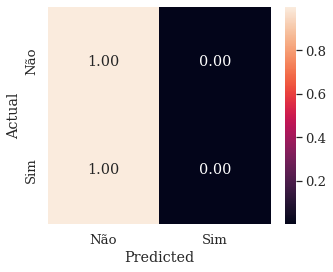

In [ ]:
cm = confusion_matrix(y_test, knn_model.predict(X_test), labels=knn_model.classes_)
# Normalise
cmn = cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#6. Árvore de Decisão

##6.1 Treinando Modelo

In [ ]:
tree_model = DecisionTreeClassifier(criterion='gini',
                                    max_depth=10,
                                    random_state=0)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

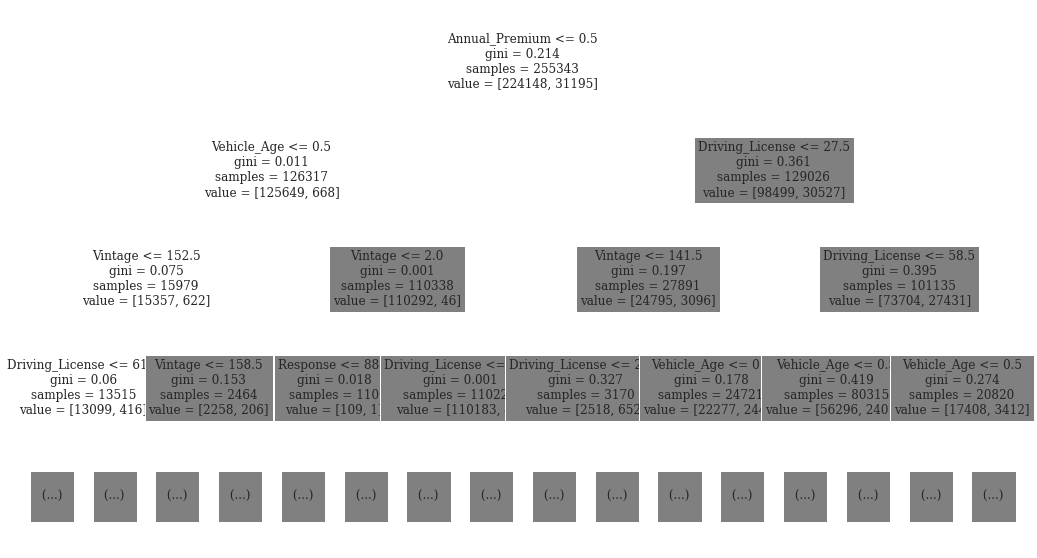

In [ ]:
plt.figure(figsize=(18,10))

ax = plot_tree(tree_model,
               max_depth=3,
               fontsize=12,
               feature_names=df_train.columns[1:])

plt.show()

## 6.2 Avaliando Modelo

In [ ]:
print(f'Acurácia (Treino): {round(accuracy_score(y_train, tree_model.predict(X_train)), 2)}')
print(f'Acurácia (Teste): {round(accuracy_score(y_test, tree_model.predict(X_test)), 2)}')

Acurácia (Treino): 0.88
Acurácia (Teste): 0.88


In [ ]:
print(classification_report(y_test, tree_model.predict(X_test), target_names=['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.88      1.00      0.93    110251
         Sim       0.24      0.00      0.00     15515

    accuracy                           0.88    125766
   macro avg       0.56      0.50      0.47    125766
weighted avg       0.80      0.88      0.82    125766



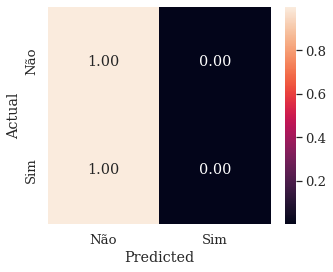

In [ ]:
cm = confusion_matrix(y_test, tree_model.predict(X_test), labels=tree_model.classes_)
# Normalise
cmn = cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#7. Regressão Logística

##7.1 Treino Modelo

In [ ]:
reglog_model = SGDClassifier(loss='log', 
                             learning_rate='constant', 
                             max_iter=250,
                             eta0=0.05, 
                             verbose=1, 
                             tol=None, 
                             random_state=0)

reglog_model.fit(X_train, y_train)

-- Epoch 1
Norm: 14032.86, NNZs: 10, Bias: 14.225000, T: 255343, Avg. loss: 7054625.025389
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 17318.56, NNZs: 10, Bias: 34.375000, T: 510686, Avg. loss: 6938599.325796
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 17846.28, NNZs: 10, Bias: 58.575000, T: 766029, Avg. loss: 6981220.470380
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 17498.80, NNZs: 10, Bias: 78.275000, T: 1021372, Avg. loss: 7026589.618499
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 17555.03, NNZs: 10, Bias: 99.675000, T: 1276715, Avg. loss: 6954615.382544
Total training time: 0.27 seconds.
-- Epoch 6
Norm: 17853.33, NNZs: 10, Bias: 122.325000, T: 1532058, Avg. loss: 6969674.374617
Total training time: 0.32 seconds.
-- Epoch 7
Norm: 18356.92, NNZs: 10, Bias: 140.625000, T: 1787401, Avg. loss: 6883414.792744
Total training time: 0.37 seconds.
-- Epoch 8
Norm: 18389.29, NNZs: 10, Bias: 164.825000, T: 2042744, Avg. loss: 6962080.681106
Total training time

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.05, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='log', max_iter=250,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=1, warm_start=False)

##7.2 Avaliando Modelo

In [ ]:
for f, c in zip(df_train.columns[1:], reglog_model.coef_[0].tolist()):
    print(f'{f} = {c}')

print(f'CONST = {float(reglog_model.intercept_)}')

Age = 90.0671236699138
Driving_License = 5391.406538363818
Region_Code = 16.26300367504131
Previously_Insured = 648.3723492345354
Vehicle_Age = -543.0070975188937
Vehicle_Damage = -180.75619942020174
Annual_Premium = 582.1832206537789
Policy_Sales_Channel = 540.5741915976199
Vintage = -16830.96011156369
Response = 1566.022114913993
CONST = 5191.241825275374


In [ ]:
print(f'Acurácia (Treino): {round(accuracy_score(y_train, reglog_model.predict(X_train)), 2)}')

Acurácia (Treino): 0.21


In [ ]:
print(f'Acurácia (Teste): {round(accuracy_score(y_test, reglog_model.predict(X_test)), 2)}')

Acurácia (Teste): 0.21


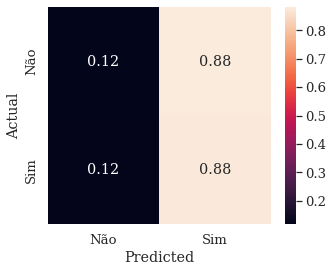

In [ ]:
cm = confusion_matrix(y_test, reglog_model.predict(X_test), labels=reglog_model.classes_)
# Normalise
cmn = cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#8. Random Forest

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=50, 
                                             criterion='entropy',
                                             max_depth=10,
                                             min_samples_split=2,
                                             random_state=0)


In [ ]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print('Random Forest')
print(f'Acurácia: {round(accuracy_score(y_test, random_forest_model.predict(X_test)), 4)}')

Random Forest
Acurácia: 0.8766


In [ ]:
print(classification_report(y_test, random_forest_model.predict(X_test), target_names=['Não', 'Sim']))

              precision    recall  f1-score   support

         Não       0.88      1.00      0.93    110251
         Sim       0.00      0.00      0.00     15515

    accuracy                           0.88    125766
   macro avg       0.44      0.50      0.47    125766
weighted avg       0.77      0.88      0.82    125766



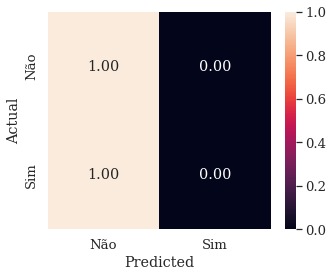

In [ ]:
cm = confusion_matrix(y_test, random_forest_model.predict(X_test), labels=random_forest_model.classes_)
# Normalise
cmn = cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#9. XGBoost

In [26]:
%%capture

xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
                                  learning_rate = 0.03,
                                  n_estimators = 100,
                                  max_depth = 3, 
                                  use_label_encoder=False)

cv = KFold(n_splits = 5, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(xgb_model, 
                           X_train, y_train, 
                           scoring = 'accuracy', 
                           cv = cv)

In [27]:
print('Validação Cruzada\n')
print(f'Acurácias: {n_scores}\n')
print(f'Acurácias (média): {round(np.mean(n_scores), 4)}')
print(f'Acurácias (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada

Acurácias: [0.87783195 0.87744033 0.87734242 0.8785345  0.8780058 ]

Acurácias (média): 0.8778
Acurácias (desvio padrão): 0.0004


In [28]:
%%capture

xgb_model.fit(X_train, y_train)

In [29]:
print('XGBoost')
print(f'Acurácia: {round(accuracy_score(y_test, xgb_model.predict(X_test)), 4)}')

XGBoost
Acurácia: 0.8766


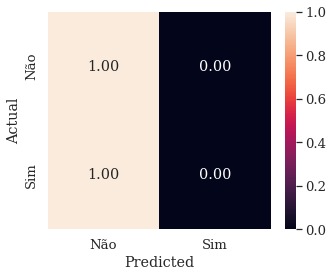

In [30]:
cm = confusion_matrix(y_test, xgb_model.predict(X_test), labels=xgb_model.classes_)
# Normalise
cmn = cm.astype('float') /  cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#10. Baleceamento + Seleção de Features 

In [31]:
train = xgboost.DMatrix(X_train,y_train,feature_names=X_train.columns)
test = xgboost.DMatrix(X_test,feature_names=X_test.columns)
xgb_params = {
    'eta':0.03,
    'max_depth':4,
    'sub_sample':0.9,
    'colsample_bytree':0.5,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'silent':0}

final_model = xgboost.train(xgb_params,train,num_boost_round=500)

In [38]:
import pickle
import numpy as np
from util import ScoreDistribution, ROC_AUC, \
    prob_scale, get_resampling, PSI, xgbCV

In [33]:
X_train_under, y_train_under = get_resampling(X_train, y_train, 
                                              verbose=False, 
                                              random_state=42, 
                                              by='undersampling', 
                                              good_mult=1)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [34]:
y_train_under.value_counts(normalize=True)

1    0.5
0    0.5
Name: bom_pagador, dtype: float64

In [35]:
train = xgboost.DMatrix(X_train_under,y_train_under,
                    feature_names=X_train_under.columns)
test = xgboost.DMatrix(X_test,feature_names=X_train_under.columns)
xgb_params = {
                    'eta':0.03,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model_under = xgboost.train(xgb_params,train,num_boost_round=500)

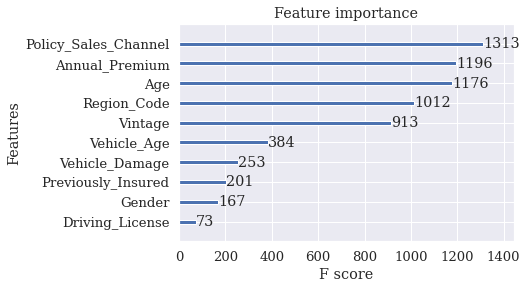

In [36]:
y_pred_train_under = final_model_under.predict(train)

xgboost.plot_importance(final_model_under)
plt.show()

# 10.Gerando Modelo

In [39]:
file_name = 'xgboost_undersampling.pkl'
pickle.dump(final_model_under, open(file_name, "wb"))